In [1]:
import pandas as pd
import time
import re
from datetime import datetime

In [2]:
# Base url to append dates to
base_url = 'http://schiphol.dutchplanespotters.nl/?date='
# Create list of dates for 2017 and 2018 (730 days)
date_range = pd.date_range('2017-01-01 00:00:00', '2018-12-31 00:00:00', freq='D').strftime('%Y-%m-%d')
# Create list of urls for all days, by appending date to base url
urls = [base_url + date for date in date_range]

In [ ]:
# Crawler: Pulls tables from the url list with one second delay after each request
# Saves to dataframe df
df = pd.DataFrame()
for i, url in enumerate(urls[:5]):
    # Pull info from url
    day_flights = pd.read_html(url)[0]
    
    # Get number of rows and current date
    num_rows = len(day_flights)
    curr_date = date_range[i]
    
    date_column = pd.Series([curr_date] * num_rows)
    day_flights['date'] = date_column
    
    df = df.append(day_flights)
    time.sleep(1)
    print('Request number: ', i)

In [ ]:
# Writes crawled information to a csv file (for raw backup)
open('schiphol-pulled-data.csv', 'w').write(df.to_csv())

In [3]:
# Read csv and drop unnecessary row and column
df = pd.read_csv('schiphol-flights-2017-2018.csv')
df = df.drop(df.columns[0], axis=1)
df = df.drop(index=0)

In [4]:
# Change column names for semantics
column_names = ['Cargo', 'Aircraft', 'Airline', 'Registration', 'Remark', 'Gate', 'Arr_FlightNr', 'Origin', 'STA', 'ETA', 'Status', 'Dep_FlightNr', 'Destination', 'STD', 'ETD', 'Status', 'Date']
df.columns = column_names

In [5]:
# This function appends the date (%Y-%m-%d) to a specified column where records
# are missing this date
def add_date_to_time(col_name):
    df_copy = df.copy()
    mask = df_copy[col_name].str.contains('\d{2}:\d{2}\Z').fillna(False)

    df_copy['Date'] = pd.to_datetime(df_copy['Date'], format='%Y-%m-%d')
    date_string = df_copy['Date'].copy()
    date_string = date_string.loc[mask]
    date_string = pd.DatetimeIndex(date_string)
    date_string = date_string.strftime('(%d-%m-%y)')

    df_copy.loc[mask, col_name] = df_copy.loc[mask, col_name].str.cat(date_string, sep =' ')
    return df_copy

# Run this function on our 4 columns and convert to datetime
df['STA'] = pd.to_datetime(add_date_to_time('STA')['STA'], format='%H:%M (%d-%m-%y)')
df['ETA'] = pd.to_datetime(add_date_to_time('ETA')['ETA'], format='%H:%M (%d-%m-%y)')
df['STD'] = pd.to_datetime(add_date_to_time('STD')['STD'], format='%H:%M (%d-%m-%y)')
df['ETD'] = pd.to_datetime(add_date_to_time('ETD')['ETD'], format='%H:%M (%d-%m-%y)')

/home/kjw/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: A future version of pandas will perform index alignment when `others` is a Series/Index/DataFrame (or a list-like containing one). To disable alignment (the behavior before v.0.23) and silence this warning, use `.values` on any Series/Index/DataFrame in `others`. To enable alignment and silence this warning, pass `join='left'|'outer'|'inner'|'right'`. The future default will be `join='left'`.
  del sys.path[0]


In [6]:
# Finally, calculate arrival and departure delays for flights
df['Arr_Delay'] = df['ETA'] - df['STA']
df['Dep_Delay'] = df['ETD'] - df['STD']

# Not all airline names are the same. We use the flight code to extract the 2 or 3 letter airline code
# and replace the 'Airline' column with these codes instead. Using our airline mapping above, we can 
# translate these back to names later
df['Airline'] = df['Arr_FlightNr'].str.extract('([A-Z]{2,3}) ', flags=re.IGNORECASE)

# Write cleaned data to csv
open('schiphol-cleaned-data-2017-2018.csv', 'w').write(df.to_csv())

146929811

In [147]:
# Airline name translation 
airline_url = 'https://en.wikipedia.org/wiki/List_of_airline_codes'
# airline_table = pd.read_html(airline_url)[3]
airline_table = pd.read_html(airline_url)[0][[0, 1, 2]]
airline_table.columns = airline_table.loc[0]
airline_table = airline_table.drop(index=0)

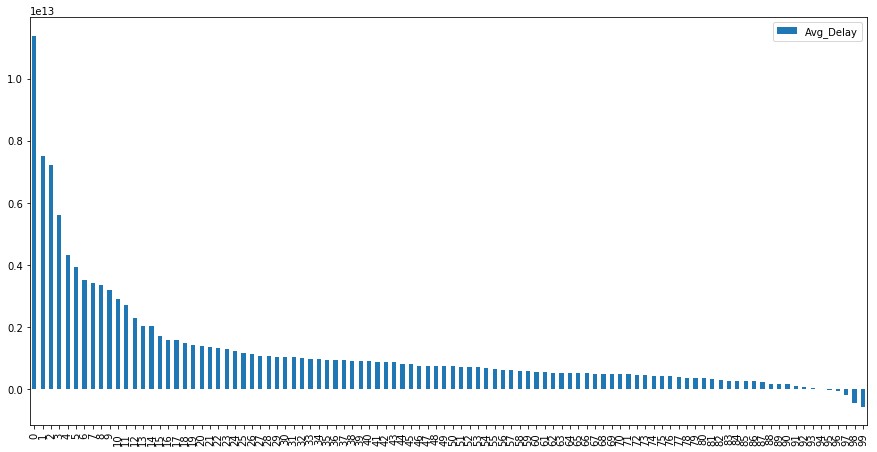

In [148]:
def top_100_airlines_by_delay():
    # Average delay per airline
    top_100_airlines = df['Airline'].value_counts()[:100]
    
    # Make copy of df and calculate Arrival, Departure and Average delay for all flights
    delays = df.copy()
    delays['Arr_Delay'] = delays['Arr_Delay'].dt.total_seconds()
    delays['Dep_Delay'] = delays['Dep_Delay'].dt.total_seconds()
    delays['Avg_Delay'] = (delays['Arr_Delay'] + delays['Dep_Delay'])/2
    
    # Get average delay per airline
    delays = delays[['Airline', 'Arr_Delay', 'Dep_Delay', 'Avg_Delay']].groupby('Airline').mean()
    
    # Convert delay from integer (seconds) to Datetime
    delays['Arr_Delay'] = pd.to_timedelta(delays['Arr_Delay'], unit='s')
    delays['Dep_Delay'] = pd.to_timedelta(delays['Dep_Delay'], unit='s')
    delays['Dep_Delay'] = pd.to_timedelta(delays['Avg_Delay'], unit='s')
    
    # Sort list by average delays
    delays = delays.loc[delays.index.isin(top_100_airlines.index)].sort_values(by='Avg_Delay', ascending=False)
    delays.reset_index(inplace=True)
    
    # Change airline 2-letter code to airline name
    for code in delays['Airline']:

        if code in airline_table['IATA'].tolist():
            airline_name = airline_table['Airline'].loc[airline_table['IATA'] == code]
            delays = delays.replace(code, airline_name.iloc[0])
        elif code in airline_table['ICAO'].tolist():
            airline_name = airline_table['Airline'].loc[airline_table['ICAO'] == code]
            delays = delays.replace(code, airline_name.iloc[0])
    
    # Convert average delay from integer to Datetime
    delays['Avg_Delay'] = (pd.to_timedelta(delays['Avg_Delay'], unit='s'))
    delays = delays[['Airline', 'Avg_Delay']]
    
    # Plot bar graph and return delays
    delays.plot.bar(figsize=(15, 7.5))
    return delays
    
top_100_airline_delays = top_100_airlines_by_delay()

In [149]:
top_100_airline_delays

,Airline,Avg_Delay
0,Cargolux,03:09:34.114114
1,AirBridge Cargo,02:04:55.971296
2,Nippon Cargo Airlines,02:00:16.695652
3,LATAM Cargo Chile,01:33:23.164556
4,Saudia,01:11:50.787401
5,Tunisair,01:05:33.951219
6,Iran Air,00:58:22.289719
7,Qatar Airways,00:56:40.023866
8,MNG Airlines,00:55:58.149779
9,Arkia Israel Airlines,00:52:56.491228


,Airline,Avg_Delay
0,Cargolux,03:09:34.114114
1,AirBridge Cargo,02:04:55.971296
2,Nippon Cargo Airlines,02:00:16.695652
3,LATAM Cargo Chile,01:33:23.164556
4,Saudia,01:11:50.787401
5,Tunisair,01:05:33.951219
6,Iran Air,00:58:22.289719
7,Qatar Airways,00:56:40.023866
8,MNG Airlines,00:55:58.149779
9,Arkia Israel Airlines,00:52:56.491228


AttributeError: 'Series' object has no attribute 'hours'